In [1]:
# 「Chest X-Ray Images(Pnuemonia)」で肺炎か診断
#  前処理

In [2]:
import numpy as np
import pandas as pd

import cv2

import matplotlib.pyplot as plt

import keras as ks
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

import os
import glob

%matplotlib inline


In [3]:
# path の設定
test_path = "./dataset/chest_xray/test/"
train_path ='./dataset/chest_xray/train/'

In [13]:
# test データ読み込み
test_dir = []
for foldername in os.listdir(test_path):
    imgs_path = test_path + foldername
    imgs = sorted(glob.glob(imgs_path + "/" + "*.jpeg"))
    
    for name in imgs:
        test_dir.append((str(name), str(foldername)))


In [14]:
# データフレームに格納
test_df = pd.DataFrame(test_dir, columns=['Images', 'Label'], index=None)

In [15]:
test_df.head()

,Images,Label
0,./dataset/chest_xray/test/NORMAL\IM-0001-0001....,NORMAL
1,./dataset/chest_xray/test/NORMAL\IM-0003-0001....,NORMAL
2,./dataset/chest_xray/test/NORMAL\IM-0005-0001....,NORMAL
3,./dataset/chest_xray/test/NORMAL\IM-0006-0001....,NORMAL
4,./dataset/chest_xray/test/NORMAL\IM-0007-0001....,NORMAL


In [18]:
# train データの読み込み
train_dir = []
for foldername in os.listdir(train_path):
    imgs_path = train_path + foldername + "/"
    imgs = sorted(glob.glob(imgs_path + "*.jpeg"))
    
    for name in imgs:
        train_dir.append((str(name), str(foldername)))


In [20]:
# データフレームに格納
train_df = pd.DataFrame(train_dir, columns=['Image', 'Label'], index=None)

In [21]:
train_df.head()

,Image,Label
0,./dataset/chest_xray/train/NORMAL\IM-0115-0001...,NORMAL
1,./dataset/chest_xray/train/NORMAL\IM-0117-0001...,NORMAL
2,./dataset/chest_xray/train/NORMAL\IM-0119-0001...,NORMAL
3,./dataset/chest_xray/train/NORMAL\IM-0122-0001...,NORMAL
4,./dataset/chest_xray/train/NORMAL\IM-0125-0001...,NORMAL


In [22]:
train_df.shape, test_df.shape

((5216, 2), (624, 2))

In [24]:
# シャッフル
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [25]:
# データのレコード数を確認
print("テストデータのレコード数：", len(test_df))
print("訓練データのレコード数：", len(train_df))

テストデータのレコード数： 624
訓練データのレコード数： 5216


In [28]:
# [NORMAL]の画像を表示してみる
# label が "NORMAL" の先頭 5件を表示する
normal_image = train_df[train_df['Label'] == 'NORMAL'].iloc[:5]

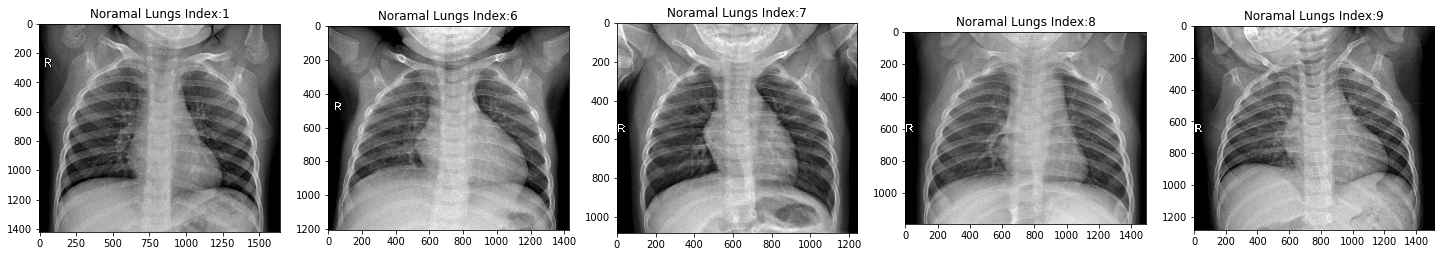

In [32]:
fig, ax = plt.subplots(1, 5, figsize=(25, 6))

plot_number = 1
for i in range(len(normal_image)):
    image = cv2.imread(normal_image['Image'].iloc[i], 1)
    ax = plt.subplot(1, 5, plot_number)
    title = 'Noramal Lungs Index:' + str(normal_image.index[i])
    plt.imshow(image)
    plt.title(title)
    plot_number += 1

In [35]:
# [Pneumonia]の画像を表示してみる
# label が "Pneumonia" の先頭 5件を表示する
pneumonia_image = train_df[train_df['Label'] == 'PNEUMONIA'].iloc[:5]

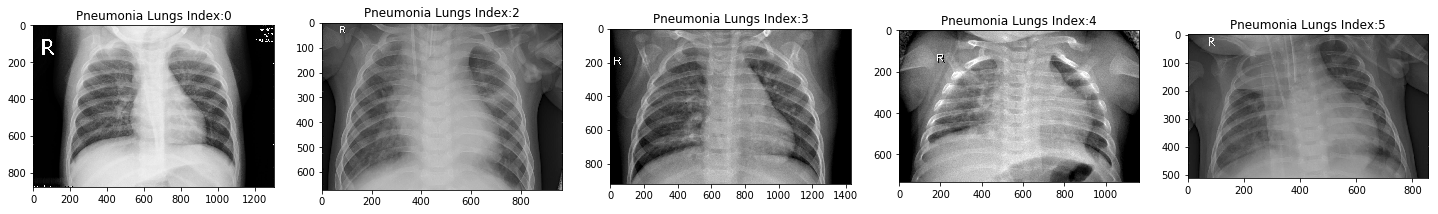

In [37]:
fig, ax = plt.subplots(1, 5, figsize=(25, 6))

plot_number = 1
for i in range(len(pneumonia_image)):
    image = cv2.imread(pneumonia_image['Image'].iloc[i], 1)
    ax = plt.subplot(1, 5, plot_number)
    title = 'Pneumonia Lungs Index:' + str(pneumonia_image.index[i])
    plt.imshow(image)
    plt.title(title)
    plot_number += 1

In [36]:
pneumonia_image.size, pneumonia_image.shape

(10, (5, 2))

Text(0.5, 1.0, 'Pneumonia')

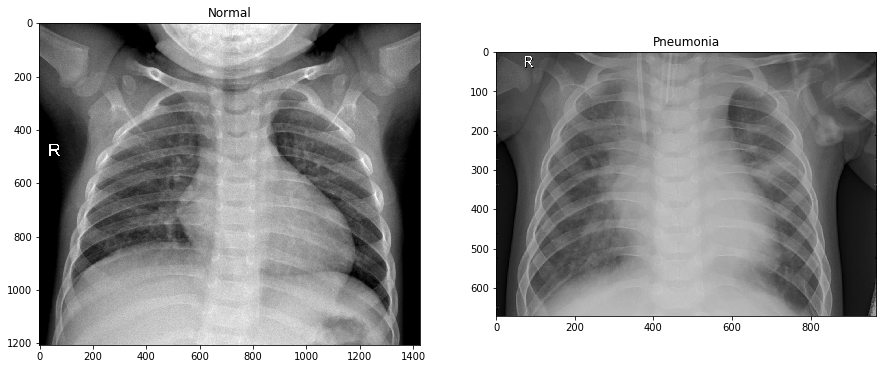

In [39]:
# 正常データと肺炎データを比較してみる
fix, ax = plt.subplots(1, 2, figsize=(15, 15))

# 正常データ
plt.subplot(121)
n_image = cv2.imread(train_df['Image'][train_df['Label'] == "NORMAL"].iloc[1], 1)
plt.imshow(n_image)
plt.title("Normal")

# 肺炎データ
plt.subplot(122)
p_image = cv2.imread(train_df['Image'][train_df['Label'] == "PNEUMONIA"].iloc[1], 1)
plt.imshow(p_image)
plt.title("Pneumonia")

In [40]:
# 今回の画像はサイズがバラバラ
# ５枚ほど確認してみる
temp = []
for i in range(5):
    img = cv2.imread(train_df['Image'][i], 1)
    temp.append(img)

temp_np = np.array(temp)

In [52]:
print(temp_np[0].shape)
print(temp_np[1].shape)
print(temp_np[2].shape)
print(temp_np[3].shape)
print(temp_np[4].shape)

(880, 1304, 3)
(1422, 1642, 3)
(672, 968, 3)
(921, 1430, 3)
(735, 1164, 3)


In [54]:
# 画像のサイズを統一
temp_list = []
for i in range(5):
    img = cv2.resize(temp[i], (64, 64))
    temp_list.append(img)

temp_resize = np.array(temp_list)
temp_resize.shape

(5, 64, 64, 3)

Text(0.5, 1.0, 'Risized')

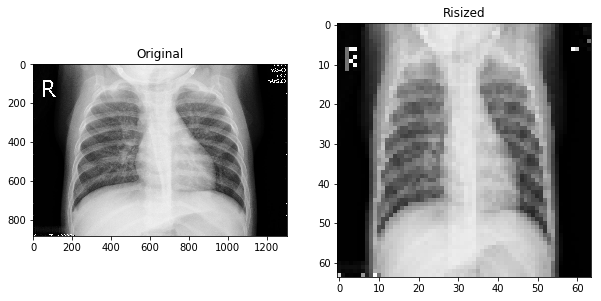

In [55]:
fix, ax = plt.subplots(1, 2, figsize=(10, 10))

# オリジナル
plt.subplot(121)
plt.imshow(temp[0])
plt.title('Original')

# リサイズ
plt.subplot(122)
plt.imshow(temp_resize[0])
plt.title('Risized')


In [56]:
# 正規化
temp_resize[0, :5, :5, 0]

array([[2, 5, 4, 3, 3],
       [2, 4, 3, 3, 2],
       [2, 1, 4, 3, 2],
       [3, 1, 3, 5, 3],
       [3, 3, 4, 4, 2]], dtype=uint8)

In [57]:
temp_resize = temp_resize.astype('float32') / 255

In [58]:
temp_resize[0, :5, :5, 0]

array([[0.00784314, 0.01960784, 0.01568628, 0.01176471, 0.01176471],
       [0.00784314, 0.01568628, 0.01176471, 0.01176471, 0.00784314],
       [0.00784314, 0.00392157, 0.01568628, 0.01176471, 0.00784314],
       [0.01176471, 0.00392157, 0.01176471, 0.01960784, 0.01176471],
       [0.01176471, 0.01176471, 0.01568628, 0.01568628, 0.00784314]],
      dtype=float32)

In [61]:
# 訓練データの前処理
img_list = []
lungs = []

# 各画像ごとに前処理
for i in range(len(train_df)):
    # 読み込み
    lungs = cv2.imread(train_df['Image'][i], 1)
    # リサイズ
    lungs = cv2.resize(lungs, (64, 64))
    # 正規化
    lungs = lungs.astype('float32') / 255
    img_list.append(lungs)

# Numpy Array
X_train = np.array(img_list)

In [62]:
X_train.shape

(5216, 64, 64, 3)

In [63]:
# テストデータの前処理
img_list = []
lungs = []

# 各画像ごとに前処理
for i in range(len(test_df)):
    # 読み込み
    lungs = cv2.imread(test_df['Images'][i], 1)
    # リサイズ
    lungs = cv2.resize(lungs, (64, 64))
    # 正規化
    lungs = lungs.astype('float32') / 255
    img_list.append(lungs)

# Numpy Array
X_test = np.array(img_list)

In [64]:
X_test.shape

(624, 64, 64, 3)

In [66]:
# ターゲット
# 正常を 0, 肺炎を 1
y_train = np.where(train_df['Label'] == "PNEUMONIA", 1, 0)
y_test = np.where(test_df['Label'] == "PNEUMONIA", 1, 0)

In [67]:
y_train[:5], y_test[:5]

(array([1, 0, 1, 1, 1]), array([1, 1, 0, 0, 1]))

In [68]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5216, 64, 64, 3), (5216,), (624, 64, 64, 3), (624,))

In [69]:
# 訓練データの保存
np.save(train_path + 'X_train.npy', X_train)
np.save(train_path + 'y_train.npy', y_train)

# テストデータの保存
np.save(test_path + 'X_test.npy', X_test)
np.save(test_path + 'y_test.npy', y_test)

In [70]:
# 保存したデータの読み出し
X_train_save = np.load(train_path + 'X_train.npy')
y_train_save = np.load(train_path + 'y_train.npy')

X_test_save = np.load(test_path + 'X_test.npy')
y_test_save = np.load(test_path + 'y_test.npy')


In [71]:
X_train_save.shape, y_train_save.shape, X_test_save.shape, y_test_save.shape

((5216, 64, 64, 3), (5216,), (624, 64, 64, 3), (624,))

In [74]:
np.all(X_train == X_train_save)

True

In [75]:
np.all(y_train == y_train_save)

True

In [76]:
np.all(X_test == X_test_save)

True

In [77]:
np.all(y_test == y_test_save)

True